# Quaternion Model

This model begins with the following Free Energy functional, with terms taken from Pusztai2005 and Dorr2010:

$$ F = \int_V (\frac{\epsilon_\phi^2T}{2}|\nabla \phi|^2 + f(\phi,c) + f_{ori}) dV \qquad (1)$$ 

In this equation, the bulk free energy, and the orientational mismatch energy are represented by the following equations:

$$ f(\phi, c) = Wg(\phi) + p(\phi)f_S + (1-p(\phi)f_L \qquad (2)$$

$$ 

In [2]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

In [243]:
def __h(phi):
    return phi*phi*phi*(10-15*phi+6*phi*phi)

def __hprime(phi):
    return (30*phi*phi*(1-phi)*(1-phi))

def __g(phi):
    return (16*phi*phi*(1-phi)*(1-phi))

def __gprime(phi):
    return (64*phi*phi*phi - 96*phi*phi +32*phi)

_h = np.vectorize(__h)
_hprime = np.vectorize(__hprime)
_g = np.vectorize(__g) 
_gprime = np.vectorize(__gprime)

def grad(phi, dx, i):
    phim = np.roll(phi, 1, 0)
    phip = np.roll(phi, -1, 0)
    return (phip-phim)/(2*dx)

def grad_l(phi, dx, i):
    phim = np.roll(phi, 1, 0)
    return (phi-phim)/(dx)

def grad_r(phi, dx, i):
    phip = np.roll(phi, -1, 0)
    return (phip-phi)/(dx)

def grad2(phi, dx):
    phim = np.roll(phi, 1, 0)
    phip = np.roll(phi, -1, 0)
    return (phip+phim-2*phi)/(dx*dx)

def divagradb(a, b, dx):
    agradb = ((a + np.roll(a, 1, 0))/2)*(np.roll(b, 1, 0) - b)/dx
    return (agradb - np.roll(agradb, -1, 0))/dx

def renormalize(q1, q2, q3, q4):
    q = np.sqrt(q1*q1+q2*q2+q3*q3+q4*q4)
    return q1/q, q2/q, q3/q, q4/q

In [204]:
#temperature
T = 873.

#bcc = 0L = e, fcc = 1S = d
#material parameters, pJ, um, K, s (except for R and Q terms, which use joules)
R = 8.314 #gas constant, J/mol*K
Q_d = 156400. #activation term in diffusivity in fcc region, J/mol
Q_e = 55290. #activation term in diffusivity in bcc region, J/mol
ceq_d = 0.1 #equilibrium concentration in fcc
ceq_e = 0.05 #equilibrium concentration in bcc
D_d0 = 1.3e8 #scaling constant of diffusion in fcc, um^2/s
D_e0 = 5.6e4 #scaling constant of diffusion in fcc, um^2/s
M_phi = 200 #mobility of phase, 1/(s*pJ)
M_qmax = 200 #maximum mobility of orientation, 1/(s*pJ)
H = 1e-3 #interfacial energy term for quaternions, pJ/(K*um)
A = 666. #energetic term in HBSM binary alloy model, A_d = A_e
w = 0.4125 #scaling of energetic hump forcing phase to be 0,1

#Temperature dependent params, since T is constant, we compute them here for now
D_d = D_d0 * np.exp(-Q_d/(R*T))
D_e = D_e0 * np.exp(-Q_e/(R*T))
print(D_d, D_e)

(0.056970096381563029, 27.534340424588464)


In [294]:
#this code block initializes the simulation

np.set_printoptions(threshold=np.inf)

res = 81
dx = 0.05
dt = dx*dx/5./D_e
d = dx*4 #interfacial thickness
ebar = 0.165 
eqbar = 0.1
print(dt)

c = np.zeros(res)
phi = np.zeros(res)
q1 = np.zeros(res)
q2 = np.zeros(res)
q3 = np.zeros(res)
q4 = np.zeros(res)
q1 += 1
c += 0.06
#c += 0.001*np.random.rand(res, res)
phi[0:res/4] = 1
q1[0:res/4] = np.cos(np.pi/8)
q2[0:res/4] = np.sin(np.pi/8)
c[0:res/4] = 0.1

phi[3*res/4:res] = 1
q1[3*res/4:res] = np.cos(np.pi/8)
q2[3*res/4:res] = np.sin(np.pi/8)
c[3*res/4:res] = 0.1
    
print(q1)
print(q2)

reference = np.zeros(res)
for i in range(res):
    reference[i] = i
    
step = 0

1.81591420855e-05
[ 0.92387953  0.92387953  0.92387953  0.92387953  0.92387953  0.92387953
  0.92387953  0.92387953  0.92387953  0.92387953  0.92387953  0.92387953
  0.92387953  0.92387953  0.92387953  0.92387953  0.92387953  0.92387953
  0.92387953  0.92387953  1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  0.92387953  0.92387953  0.92387953  0.92387953  0.92387953  0.92387953
  0.92387953  0.92387953  0.92387953  0.92387953  0.92387953  0.92387953
  0.92387953  0.92387953  0.92387953  0.92387953  0.92387953  0.92387953
  0.92387953  0.92387953  0.92387953]
[ 0.38268343  0.38268343  0.38268343  0.3826

In [362]:
# This block runs the simulation for some number of time steps

#add these values after evolving the simulation to almost stability - to test if the interface in phi is truly stable
#phi = np.zeros(res)
#phi += 1

time_steps = 1000

# original number is the one used in Pusztai2005 and Granasy2014
# multiplication factor is used to ensure q is stable

for i in range(time_steps):
    step += 1
    #print(i)
    g = _g(phi)
    h = _h(phi)
    m = 1-h;
    p = phi*phi
    pp = 2*phi
    hprime = _hprime(phi)
    gprime = _gprime(phi)
    
    c_d = c - m*(ceq_e - ceq_d)
    c_e = c - h*(ceq_d - ceq_e)
    f_d = A*(c_d - ceq_d)*(c_d - ceq_d)
    f_e = A*(c_e - ceq_e)*(c_e - ceq_e)
    mu = h*2*A*(c_d - ceq_d) + m*2*A*(c_e - ceq_e)
    
    
    phixx = grad2(phi, dx)
    lphi = phixx
    phix = grad(phi, dx, i)
    gq1l = grad_l(q1, dx, i)
    gq2l = grad_l(q2, dx, i)
    gq3l = grad_l(q3, dx, i)
    gq4l = grad_l(q4, dx, i)
    gqsl = gq1l*gq1l+gq2l*gq2l+gq3l*gq3l+gq4l*gq4l
    
    gq1r = np.roll(gq1l, -1, 0)
    gq2r = np.roll(gq2l, -1, 0)
    gq3r = np.roll(gq3l, -1, 0)
    gq4r = np.roll(gq4l, -1, 0)
    
    gq1 = (gq1l+gq1r)/2
    gq2 = (gq2l+gq2r)/2
    gq3 = (gq3l+gq3r)/2
    gq4 = (gq4l+gq4r)/2
    
    #print(gq1)
    smallest = 1e-1
    #print(gqs)
    
    gqsr = np.roll(gqsl, -1, 0)
    gqs = (gqsl+gqsr)/2
    rgqs_0 = np.sqrt(gqs)
    
    for i in range(res):
        if(gqsl[i] < smallest):
            gqsl[i] = smallest
              
    gqsr = np.roll(gqsl, -1, 0)
    rgqsl = np.sqrt(gqsl)
    rgqsr = np.roll(rgqsl, -1, 0)
    
    gqs = (gqsl+gqsr)/2
    rgqs = np.sqrt(gqs)
    
    lq1 = grad2(q1, dx)
    lq2 = grad2(q2, dx)
    lq3 = grad2(q3, dx)
    lq4 = grad2(q4, dx)
    gqs2 = gq1*lq1+gq2*lq2+gq3*lq3+gq4*lq4
    
    
    
    #change in c
    D_C = h*D_d + m*D_e
    temp = D_C*hprime*(c_e-c_d)
    #deltac = D_C*(grad2(c, dx))+(grad(D_C, dx, i)*grad(c, dx, i))+temp*(lphi)+(grad(temp, dx, i)*phix)
    deltac = divagradb(D_C, c, dx) + divagradb(temp, phi, dx)
    #print(deltac)
    #print(temp)
    
    #change in phi
    deltaphi = M_phi*(ebar*ebar*lphi+hprime*(f_e - f_d - mu*(ceq_e-ceq_d))-w*gprime-2*H*T*pp*rgqs_0)
    #randArray = 2*np.random.rand(res)-1
    #alpha = 0.3
    #deltaphi += M_phi*alpha*randArray*(16*g)*((1-c)*H_A+c*H_B)
    
    #changes in q
    M_q = 1e-6 + (M_qmax-1e-6)*m
    
    
    gaq1 = ((0.5*(p+np.roll(p, -1, 0))*gq1r/rgqsr)-(0.5*(p+np.roll(p, 1, 0))*gq1l/rgqsl))/(dx)
    gaq2 = ((0.5*(p+np.roll(p, -1, 0))*gq2r/rgqsr)-(0.5*(p+np.roll(p, 1, 0))*gq2l/rgqsl))/(dx)
    gaq3 = ((0.5*(p+np.roll(p, -1, 0))*gq3r/rgqsr)-(0.5*(p+np.roll(p, 1, 0))*gq3l/rgqsl))/(dx)
    gaq4 = ((0.5*(p+np.roll(p, -1, 0))*gq4r/rgqsr)-(0.5*(p+np.roll(p, 1, 0))*gq4l/rgqsl))/(dx)
    t1 = eqbar*eqbar*lq1+H*T*(gaq1)
    t2 = eqbar*eqbar*lq2+H*T*(gaq2)
    t3 = eqbar*eqbar*lq3+H*T*(gaq3)
    t4 = eqbar*eqbar*lq4+H*T*(gaq4)
    second = (q1*t1+q2*t2+q3*t3+q4*t4)
    deltaq1 = M_q*(t1-q1*second)
    deltaq2 = M_q*(t2-q2*second)
    deltaq3 = M_q*(t3-q3*second)
    deltaq4 = M_q*(t4-q4*second)
    #print(deltaq1)
    
    #apply changes
    #deltaphi[0] = 0
    #deltac[0] = 0
    #deltaq1[0] = 0
    #deltaq2[0] = 0
    #deltaq3[0] = 0
    #deltaq4[0] = 0
    #deltaphi[res-1] = 0
    #deltac[res-1] = 0
    #deltaq1[res-1] = 0
    #deltaq2[res-1] = 0
    #deltaq3[res-1] = 0
    #deltaq4[res-1] = 0
    #print(c)
    #print(phi)
    #print(q1)
    #print(q2)
    #print(q3)
    #print(q4)
    #print(gqs)
    #print("gp2r:", gp2r)
    #print("Second: ", second)
    #print("t4:", t4)
    
    ctemp = c.copy()
    c += deltac*dt
    phi += deltaphi*dt
    q1 += deltaq1*dt
    q2 += deltaq2*dt
    q3 += deltaq3*dt
    q4 += deltaq4*dt
    if(i%10 == 0):
        q1, q2, q3, q4 = renormalize(q1, q2, q3, q4)

#print(c)
#print(phi)
#print(q1)
#print(q2)
#print(q3)
#print(q4)    
print("Done")

Done


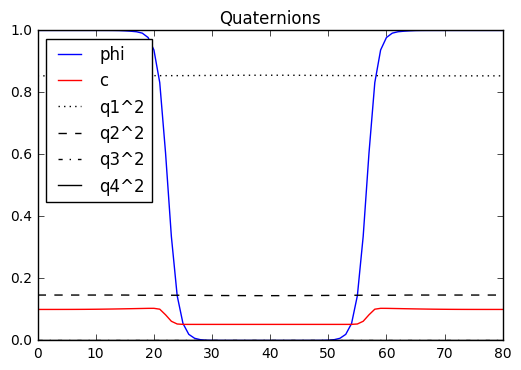

In [363]:
# This code block prints the current graph of the interface

plt.rcParams['figure.figsize'] = 6, 4
plt.title('Quaternions')
plt.plot(reference,phi, 'b')
plt.plot(reference,c, 'r')
plt.plot(reference,q1*q1,'k:')
plt.plot(reference,q2*q2,'k--')
plt.plot(reference,q3*q3,'k-.')
plt.plot(reference,q4*q4,'k')
plt.legend(['phi', 'c', 'q1^2', 'q2^2', 'q3^2', 'q4^2'], loc=2)
plt.savefig('graph'+str(step)+'.png')

In [251]:
#This code block prints out the d(phi)/dt array, to see if the interface is stable

print(sum(c))
print(c)


6.46
[ 0.103768    0.10356954  0.10316219  0.1025971   0.10196339  0.10136038
  0.10086231  0.10050017  0.10026593  0.10012995  0.10005855  0.10002441
  0.10000945  0.10000341  0.10000115  0.10000036  0.10000011  0.10000003
  0.10000001  0.1         0.1         0.10000001  0.10000003  0.10000011
  0.10000036  0.10000115  0.10000341  0.10000945  0.10002441  0.10005855
  0.10012995  0.10026593  0.10050017  0.10086231  0.10136038  0.10196339
  0.1025971   0.10316219  0.10356954  0.103768    0.10367271  0.10139
  0.08508762  0.06336054  0.05344769  0.05199873  0.05190657  0.0519048
  0.05190712  0.05190942  0.05191153  0.05191344  0.05191516  0.05191668
  0.051918    0.05191912  0.05192004  0.05192075  0.05192126  0.05192157
  0.05192167  0.05192157  0.05192126  0.05192075  0.05192004  0.05191912
  0.051918    0.05191668  0.05191516  0.05191344  0.05191153  0.05190942
  0.05190712  0.0519048   0.05190657  0.05199873  0.05344769  0.06336054
  0.08508762  0.10139     0.10367271]


In [144]:
gmu = grad(mu, dx, 0)
dgmu = gmu*D_C
gdgmu = grad(dgmu, dx, 0)
print(gdgmu)
gdgmu2 = D_C*grad2(mu, dx) + grad(D_C, dx, 0) * grad(mu, dx, 0)
print(gdgmu2)
print(deltac)
print(grad2(c, dx))

[ -1.30808314e+10   7.58841684e+01   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.47434614e-12
  -1.92507482e-10  -1.34913203e-08  -9.39518233e-07  -6.54266615e-05
  -4.55596890e-03  -3.17246863e-01  -2.20907562e+01  -1.53823529e+03
  -1.07111145e+05  -7.45841393e+06  -5.19347789e+08  -3.61634695e+10
  -2.51815171e+12  -1.75345124e+14  -9.79290145e+13   5.06499692e+16
   2.62153585e+16  -3.24716399e+16  -1.37041415e+16  -9.44728271e+15
  -6.51271376e+15  -4.48969739e+15  -3.09508192e+15  -2.13366988e+15
  -1.47089715e+15  -1.01399867e+15  -6.99024607e+14  -4.81889588e+14
  -3.32202289e+14  -2.29011715e+14  -1.57874787e+14  -1.08834818e+14
  -7.50279239e+13  -5.17223203e+13